<a href="https://colab.research.google.com/github/sergioar3143/AprendizajeProfundo/blob/main/Clasificacion_grupo_etario_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import correlate2d, convolve2d
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import PIL
import copy
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
from sklearn.model_selection import train_test_split
import torchvision as tv

##Audio
from torchaudio.datasets import SPEECHCOMMANDS
from tqdm.auto import trange
import collections
import torchaudio.transforms as T
import librosa
import random
import IPython as ip

# Por reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

!pip install gdown
import gdown
import os

URL_trainval="https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86"
if not os.path.exists("./fairface-img-margin025-trainval.zip"):
  gdown.download(URL_trainval, "./fairface-img-margin025-trainval.zip", quiet=False)

URL_train_csv="https://drive.google.com/uc?id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH"
if not os.path.exists("./fairface_label_train.csv"):
  gdown.download(URL_train_csv, "./fairface_label_train.csv", quiet=False)

URL_val_csv="https://drive.google.com/uc?id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D"
if not os.path.exists("./fairface_label_val.csv"):
  gdown.download(URL_val_csv, "./fairface_label_val.csv", quiet=False)

if not os.path.exists("./FairFace"):
    !unzip "./fairface-img-margin025-trainval.zip" -d "./FairFace"

Downloading...
From: https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
To: /content/fairface-img-margin025-trainval.zip
100%|██████████| 578M/578M [00:08<00:00, 64.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
To: /content/fairface_label_train.csv
100%|██████████| 3.79M/3.79M [00:00<00:00, 77.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D
To: /content/fairface_label_val.csv
100%|██████████| 448k/448k [00:00<00:00, 17.4MB/s]


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ./FairFace/val/5370.jpg  
  inflating: ./FairFace/val/5596.jpg  
  inflating: ./FairFace/val/5875.jpg  
  inflating: ./FairFace/val/5878.jpg  
  inflating: ./FairFace/val/5879.jpg  
  inflating: ./FairFace/val/5883.jpg  
  inflating: ./FairFace/val/6126.jpg  
  inflating: ./FairFace/val/6132.jpg  
  inflating: ./FairFace/val/6144.jpg  
  inflating: ./FairFace/val/6150.jpg  
  inflating: ./FairFace/val/6340.jpg  
  inflating: ./FairFace/val/7190.jpg  
  inflating: ./FairFace/val/7734.jpg  
  inflating: ./FairFace/val/7747.jpg  
  inflating: ./FairFace/val/7872.jpg  
  inflating: ./FairFace/val/7940.jpg  
  inflating: ./FairFace/val/8065.jpg  
  inflating: ./FairFace/val/8069.jpg  
  inflating: ./FairFace/val/8125.jpg  
  inflating: ./FairFace/val/8202.jpg  
  inflating: ./FairFace/val/8204.jpg  
  inflating: ./FairFace/val/8205.jpg  
  inflating: ./FairFace/val/8268.jpg  
  inflating: ./FairFace/val/8270.jpg  
  i

In [ ]:
df_train = pd.read_csv('./fairface_label_train.csv')
df_val = pd.read_csv('./fairface_label_val.csv')
df_train.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [ ]:
clase=list(np.unique(df_train['age']))
clase_a_ind = {c:i for i,c in enumerate(clase)}
ind_a_clase = {i:c for i,c in enumerate(clase)}

for i in clase:
  print(f'A la clase de {i} años le corresponde el indice {clase_a_ind[i]}')

A la clase de 0-2 años le corresponde el indice 0
A la clase de 10-19 años le corresponde el indice 1
A la clase de 20-29 años le corresponde el indice 2
A la clase de 3-9 años le corresponde el indice 3
A la clase de 30-39 años le corresponde el indice 4
A la clase de 40-49 años le corresponde el indice 5
A la clase de 50-59 años le corresponde el indice 6
A la clase de 60-69 años le corresponde el indice 7
A la clase de more than 70 años le corresponde el indice 8


In [ ]:
df_train['ind']=0
df_val['ind']=0
for i in clase:
  idx=df_train.loc[:,'age']==i
  df_train.loc[idx, 'ind']=clase_a_ind[i]

  idx=df_val.loc[:,'age']==i
  df_val.loc[idx, 'ind']=clase_a_ind[i]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train['file'], df_train['ind'], test_size=0.3, random_state=42, shuffle=True, stratify=df_train['ind'])
X_test , y_test = df_val['file'], df_val['ind']

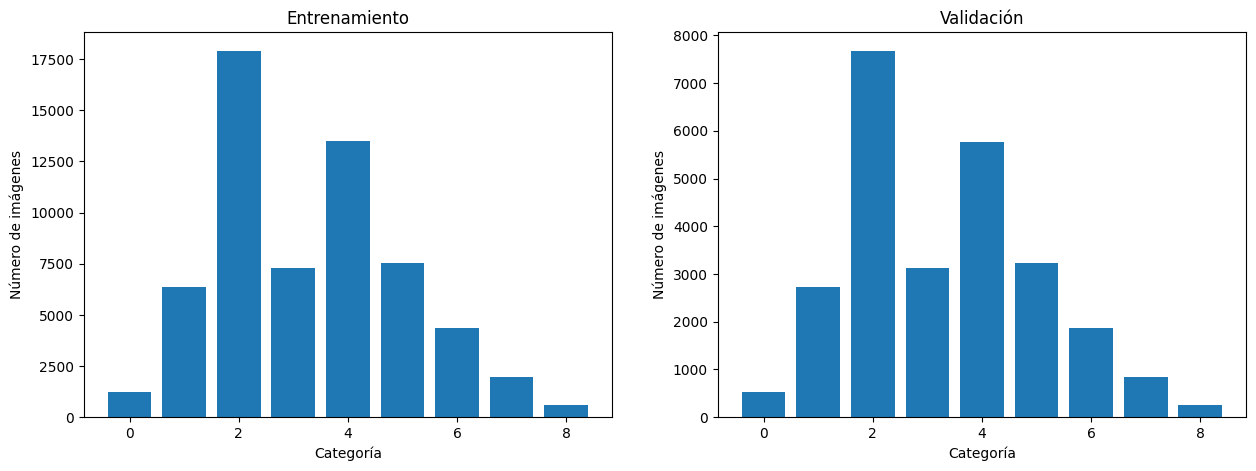

In [ ]:
idx_ent, cuentas_ent = np.unique(y_train, return_counts=True)
idx_val, cuentas_val = np.unique(y_val, return_counts=True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].bar(x=idx_ent, height=cuentas_ent)
axs[0].set_title('Entrenamiento')
axs[0].set_xlabel('Categoría')
axs[0].set_ylabel('Número de imágenes')

axs[1].bar(x=idx_val, height=cuentas_val)
axs[1].set_title('Validación')
axs[1].set_xlabel('Categoría')
axs[1].set_ylabel('Número de imágenes')

plt.show()

In [ ]:
class Face_age(Dataset):
  def __init__(self, x, y, raiz, transform = None):
    self.x = x
    self.y = y
    self.raiz = raiz
    self.transform = transform
    self.disp = 'cuda' if torch.cuda.is_available() else 'cpu'

  def __getitem__(self, idx):
    img = PIL.Image.open(self.raiz+"/"+self.x.iloc[idx])
    cat = self.y.iloc[idx]
    cat = nn.functional.one_hot(torch.tensor(cat), num_classes=9)
    cat = cat.to(dtype=torch.float32, device=self.disp)

    if self.transform:
      img = self.transform(img)
      img = img.to(self.disp)

    return img, cat

  def __len__(self):
    return len(self.x)


In [ ]:
dir_raiz = 'FairFace'
ds_ent = Face_age(X_train, y_train, dir_raiz)
ds_ent.disp="cpu"

In [ ]:
it_ent = iter(ds_ent)
img_ent, cat_ent = next(it_ent)

cat_ent=cat_ent.cpu().numpy()
cat_ent=np.argmax(cat_ent)

print(f'Imagen = {img_ent}, Categoría = {cat_ent}')

Imagen = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7E654E283D00>, Categoría = 7


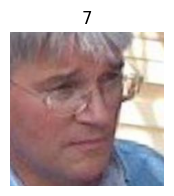

(224, 224)


In [ ]:
plt.figure(figsize = (2,2))
plt.imshow(img_ent)
plt.title(cat_ent)
plt.axis('off')
plt.show()
print(img_ent.size)

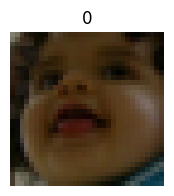

In [ ]:
IMG_SIZE = 32

tsfm = transforms.Compose([
    transforms.Resize(IMG_SIZE,antialias = True),
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tsfm2 = transforms.Compose([transforms.RandomResizedCrop(IMG_SIZE, scale = (0.85, 1.0),antialias = True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(),
                            #transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dir_raiz = 'FairFace'
ds_ent = Face_age(X_train, y_train, dir_raiz, transform=tsfm2)
it_ent = iter(ds_ent)
img_ent, cat_ent = next(it_ent)
img_ent, cat_ent = next(it_ent)

cat_ent=cat_ent.cpu().numpy()
cat_ent=np.argmax(cat_ent)

plt.figure(figsize = (2,2))
plt.imshow(img_ent.permute(1, 2, 0).cpu().numpy())
plt.title(cat_ent)
plt.axis('off')
plt.show()

In [ ]:
dir_raiz = 'FairFace'
trn_ds = Face_age(X_train, y_train, dir_raiz, transform=tsfm2)
val_ds = Face_age(X_val, y_val, dir_raiz, transform=tsfm)

trn_dl = DataLoader(trn_ds, batch_size=128, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)

In [ ]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
  estado_modelo = {'epoch': epoca,
                   'model_state_dict': modelo.state_dict(),
                   'optimizer_state_dict': opt.state_dict()}
  torch.save(estado_modelo, ckptpath)

In [ ]:
def registra_info_tboard(writer, epoca, hist):
  for (m,v) in hist.items():
    writer.add_scalar(m, v[epoca], epoca)

In [ ]:
def exactitud(y_hat, y):
  cmp = y_hat.argmax(dim=-1) == y.argmax(dim=-1)
  #cmp = y_hat.argmax(dim=-1) == y
  aciertos = torch.count_nonzero(cmp)
  return aciertos / cmp.shape[0]

In [ ]:
def paso_ent(modelo,
             fp,
             metrica,
             opt,
             X,
             y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with torch.no_grad():
    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
    metricas_paso = metrica(y_hat, y)

  return perdida_paso, metricas_paso

In [ ]:
def entrena(modelo,
            fp,
            metrica,
            opt,
            entdl,
            valdl,
            disp,
            ckptpath,
            n_epocas = 10,
            tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {'perdida_ent':np.zeros(n_epocas),
          'perdida_val': np.zeros(n_epocas),
          metrica.__name__ + '_ent': np.zeros(n_epocas),
          metrica.__name__ + '_val': np.zeros(n_epocas)}

  tbwriter = SummaryWriter(tbdir)
  perdida_min = torch.inf
  mejor_modelo = copy.deepcopy(modelo)

  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for p, (Xlote,ylote) in enumerate(entdl):
      #print(Xlote.shape)
      Xlote = Xlote.to(disp)
      ylote = ylote.to(disp)

      perdida_paso, metrica_paso = paso_ent(modelo,
                                            fp,
                                            metrica,
                                            opt,
                                            Xlote,
                                            ylote)

      hist['perdida_ent'][e] += perdida_paso
      hist[metrica.__name__ + '_ent'][e] += metrica_paso

    # bucle de validación
    modelo.eval()
    with torch.no_grad():
      for Xlote,ylote in valdl:
        Xlote = Xlote.to(disp)
        ylote = ylote.to(disp)

        y_hat = modelo(Xlote)

        hist['perdida_val'][e] += fp(y_hat, ylote)
        hist[metrica.__name__ + '_val'][e] += metrica(y_hat, ylote)

    hist['perdida_ent'][e] /=  n_lotes_ent
    hist[metrica.__name__ + '_ent'][e] /= n_lotes_ent
    hist['perdida_val'][e] /=  n_lotes_val
    hist[metrica.__name__ + '_val'][e] /= n_lotes_val

    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['perdida_val'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    registra_info_tboard(tbwriter, e, hist)

    print(f'\nÉpoca {e}: '
          f'Perdida(E) = {hist["perdida_ent"][e]:.3f}, '
          f'{metrica.__name__}(E) = {hist[metrica.__name__ + "_ent"][e]:.3f}, '
          f'Perdida(V) = {hist["perdida_val"][e]:.3f}, '
          f'{metrica.__name__}(V) = {hist[metrica.__name__ + "_val"][e]:.3f}')

  return modelo, mejor_modelo, hist

In [ ]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        out_channels1, out_channels2 = out_channels

        if in_channels != out_channels2:
          self.conv1x1 = nn.Conv2d(in_channels, out_channels2, 1)
        else:
          self.conv1x1 = None

        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_block = nn.Sequential(
            # conv1
            # [N, I, H, W] => [N, O1, H, W]
            ##Depthwise conv
            nn.Conv2d(in_channels, out_channels2, kernel_size=7, groups=in_channels, padding = 'same'),
            # [N, O1, H, W]
            nn.GroupNorm(1, out_channels2),
            # [N, O1, H, W]
            nn.Conv2d(out_channels2, out_channels1 ,kernel_size=1),
            nn.GELU(),
            # conv2
            # [N, O1, H, W] => [N, O2, H, W]
            nn.Conv2d(out_channels1,out_channels2, kernel_size=1, padding = 'same'),
            # [N, O2, H, W]
        )

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_block(x)
        # [N, O2, H, W]
        if self.conv1x1:
          x = self.conv1x1(x)
        x = x1 + x
        return x

In [ ]:
class DeepConv(nn.Module):

    def __init__(self):
        super(DeepConv, self).__init__()
        self.num_feats = 768
        # [N, 3, 32, 32] => [N, 96, 16, 16]
        self.cnn = nn.Sequential(
            # [N, 3, 32, 32] => [N, 96, 32, 32]
            ConvBlock(in_channels=3, out_channels=(384,96)),
            # [N, 96, 32, 32] => [N, 96, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 96, 16, 16] => [N, 192, 16, 16]
            ConvBlock(in_channels=96, out_channels=(768,192)),
            # [N, 192, 16, 16] => [N, 192, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 192, 8, 8] => [N, 384, 8, 8]
            ConvBlock(in_channels=192, out_channels=(1536,384)),
            # [N, 384, 8, 8] => [N, 384, 4, 4]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 384, 4, 4] => [N, 768, 4, 4]
            ConvBlock(in_channels=384, out_channels=(3072,768))
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        # [N, 3, 32, 32] => [N, 3x32x32]
        # [N, 3x32x32] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 9)

    def forward(self, x):
        # [N, 3, 64, 64] => [N, 3, 32, 32]
        x = self.cnn(x)
        x = self.gap(x)
        # [N, 3, 32, 32] => [N, 3x32x32]
        x = torch.flatten(x,1)
        # [N, 3x32x32] => [N, 1]
        x = self.cls(x)
        return nn.functional.softmax(x,dim=1)


Época 0: Perdida(E) = 2.081, exactitud(E) = 0.293, Perdida(V) = 2.075, exactitud(V) = 0.299

Época 1: Perdida(E) = 2.073, exactitud(E) = 0.303, Perdida(V) = 2.071, exactitud(V) = 0.307

Época 2: Perdida(E) = 2.070, exactitud(E) = 0.308, Perdida(V) = 2.069, exactitud(V) = 0.309

Época 3: Perdida(E) = 2.065, exactitud(E) = 0.315, Perdida(V) = 2.068, exactitud(V) = 0.313

Época 4: Perdida(E) = 2.061, exactitud(E) = 0.319, Perdida(V) = 2.056, exactitud(V) = 0.324

Época 5: Perdida(E) = 2.056, exactitud(E) = 0.325, Perdida(V) = 2.057, exactitud(V) = 0.323

Época 6: Perdida(E) = 2.052, exactitud(E) = 0.329, Perdida(V) = 2.062, exactitud(V) = 0.318

Época 7: Perdida(E) = 2.048, exactitud(E) = 0.334, Perdida(V) = 2.052, exactitud(V) = 0.328

Época 8: Perdida(E) = 2.044, exactitud(E) = 0.340, Perdida(V) = 2.045, exactitud(V) = 0.335

Época 9: Perdida(E) = 2.040, exactitud(E) = 0.343, Perdida(V) = 2.049, exactitud(V) = 0.332

Época 10: Perdida(E) = 2.037, exactitud(E) = 0.348, Perdida(V) = 2.04

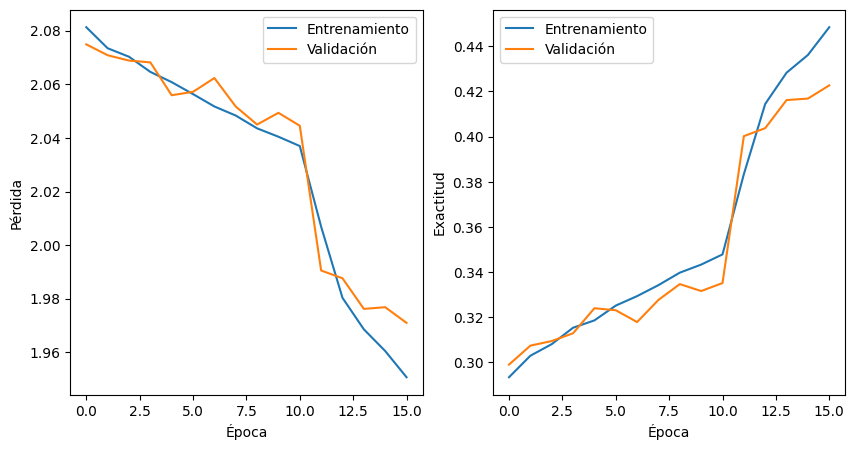

In [ ]:
#ecm = nn.MSELoss()
model = DeepConv()
disp = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(disp)
ecm = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.1)
opt = Adam(model.parameters(),lr=0.0001)

#opt = SGD(model.parameters(), lr = 1e-3)

LOGDIR = './logs/'

model, mejor_conv, hist = entrena(model,
                                   ecm,
                                   exactitud,
                                   opt,
                                   trn_dl,
                                   val_dl,
                                   disp,
                                   LOGDIR + '/conv.pt',
                                   n_epocas=16,
                                   tbdir = LOGDIR)

f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()